### 序列模型

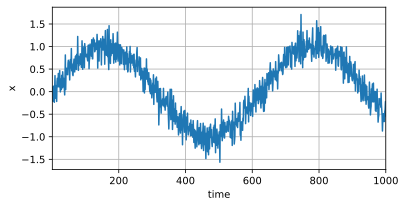

In [47]:
#prepare data
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [48]:
#马尔可夫假设
tau = 4
#构造996*4的特征矩阵，其中一行为一个样本，每个样本中有4个data
features = torch.zeros((T - tau, tau))
for i in range(tau):
    '''对于所有行，每次选定第i列进行填充，第i列的第一个数为从x中采样的起始长度为τ的数组中的第i个数，
    剩余数据从该数往后排到x中第T-τ+i个数'''
    features[:, i] = x[i: T - tau + i]
#第一组长度为τ的样本不需要预测，所以从tau+1开始将x中的数存入label
#并将维度变换为996*1
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


In [46]:
# T = 10
# tau = 4
# features = torch.zeros((T-tau,tau))
# # print(features)
# for i in range(tau):
#     features[:,i] = x[i:T-tau+i]
# print(features)
# print(x[tau:].shape)

In [49]:
#building model
def init_weights(m):
    if type(m)==nn.Linear:
        #xavier根据输入输出的形状来适配权重的形状
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    net.apply(init_weights)
    return net
net = get_net()

In [50]:
#construct loss and optimizer
#由于是数值上的逼近故用MSE(Mean Square Error)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(),0.01)

In [51]:
#train cycle
def train(net,train_iter,epochs):
    for epoch in range(epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        print(f'epoch{epoch+1},'
              f'loss:{d2l.evaluate_loss(net,train_iter,loss)}')
train(net,train_iter,100)

epoch1,loss:0.07841463161534384
epoch2,loss:0.062240662053227425
epoch3,loss:0.05884241798010312
epoch4,loss:0.05780566902831197
epoch5,loss:0.05636281505423157
epoch6,loss:0.05490875008859133
epoch7,loss:0.053270871603959484
epoch8,loss:0.052921691566313565
epoch9,loss:0.051884021266902745
epoch10,loss:0.051885489962602914
epoch11,loss:0.051078458561709054
epoch12,loss:0.050550312931208236
epoch13,loss:0.05048241941748481
epoch14,loss:0.05062035245722846
epoch15,loss:0.05016938763621606
epoch16,loss:0.049856764509489664
epoch17,loss:0.050049993405608756
epoch18,loss:0.04947348492906282
epoch19,loss:0.04885617182835152
epoch20,loss:0.04938298841252139
epoch21,loss:0.049089159571418635
epoch22,loss:0.04894938050328117
epoch23,loss:0.04867675775465997
epoch24,loss:0.04845904696144556
epoch25,loss:0.04833805193438342
epoch26,loss:0.0487921834727259
epoch27,loss:0.04835618478491118
epoch28,loss:0.04783818062002722
epoch29,loss:0.047707355581223965
epoch30,loss:0.04738034842241751
epoch31,l

[-0.03375409  0.10122305 -0.21292867  0.12055734  0.068912  ]


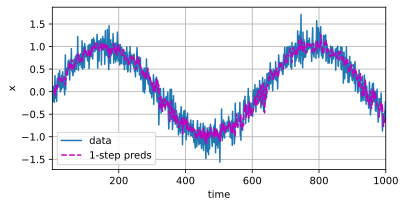

In [62]:
#单步预测效果
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',
    legend=['data','1-step preds'],xlim=[1,1000],figsize=(6,3)
)
print(x.detach().numpy()[:5])


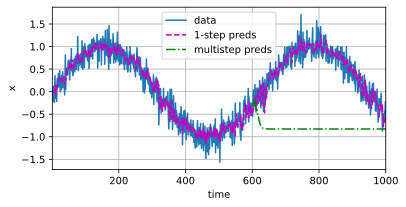

In [63]:
#多步
multistep_preds = torch.zeros(T)
#只给出前600+4个数据
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

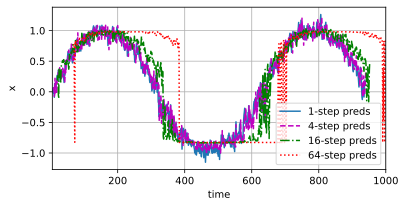

In [64]:
#不同步数的效果
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))